# Week 8: Stochastic simulations 

<hr>

## Learning Objectives
- Convert a system of differential equations into a set of state changes and propensities 
- Sample from an exponential distribution to simulate how long it will take for Poisson process to occur
- Repeatedly use the propensities and draws from an exponential distribution to stochastically simulate a system evolving over time
- Compare the results of stochastic simulation to the deterministic behavior

In [9]:
import numpy as np
import numba
import random
import matplotlib.pyplot as plt
import scipy.integrate

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

We will use the same strategy for simulating dynamics of a differential equation. We will find a way to *sample* out of the distribution that is governed by the master equation. This technique was pioneered by Dan Gillespie in the last 70s. For that reason, these sampling techniques are often called **Gillespie simulations**. The algorithm is sometimes referred to as a **stochastic simulation algorithm**, or SSA.

Here, we will explore how this algorithm works by looking at simple production of a protein.

## The dynamical equations

For simple protein production, we have the following reactions.

\begin{align}
\text{DNA} \rightarrow \text{mRNA} \rightarrow \text{protein}
\end{align}

### Macroscale equations
As we've seen before, the deterministic dynamics, which describe mean concentrations over a large population of cells, are described by the ODEs

$$ \frac{\mathrm{d}m}{\mathrm{d}t} = \beta_m - \gamma_m m,$$

$$ \frac{\mathrm{d}p}{\mathrm{d}t} = \beta_p m - \gamma_p p.$$

## The Gillespie algorithm

The transition probabilities are also called **propensities** in the context of stochastic simulation. The propensity for a given transition, say indexed $i$, is denoted as $a_i$. 

To cast this problem for a Gillespie simulation, we can write each change of state (moving either the copy number of mRNA or protein up or down by 1 in this case) and their respective propensities.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & \gamma_m m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma_p p.
\end{array}
\end{align}

The basic idea is that events (such as those outlined above) are rare, discrete, separate events.  I.e., each event is an arrival of a Poisson process.  The Gillespie algorithm starts with some state, $(m_0,p_0)$.  Then a state change, *any* state change, will happen in some time $\Delta t$ that has a certain probability distribution (which we will show is Exponential momentarily).  The probability that the state change that happens is reaction $j$ is proportional to $a_j$.  That is to say, state changes with high propensities are more likely to occur.  Thus, choosing which of the $n$ state changes happens in $\Delta t$ is a matter of drawing an integer $j$ in $[1,n]$ where the probability of drawing $j$ is

$$ \frac{a_j}{\sum_i a_i} $$

Now, how do we determine how long the state change took? We can consider each possible stage change as a Poisson process that occurs with rate $a_i$. And as we saw last semester, the time it takes for the arrival of a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process) is [Exponentially distributed](https://en.wikipedia.org/wiki/Exponential_distribution). So the wait time for each given event will be exponentially distributed with mean wait time of $1/a_i$. 

But we are interested in the chance of **any** of our state changes occurring. Since we consider each of the possible events as being independent from each other, the rate at with **any** event occurs will be the sum of all $a_i$, and accordingly the wait time for *something* to occur will be exponentially distributed with mean $1/\sum a_i$.

With these consideration in place, the Gillespie algorithm then proceeds as follows:

>1. Choose an initial condition, e.g., $m = p = 0$.
2. Calculate the propensity for each of the enumerated state changes.  The propensities may be functions of $m$ and $p$, so they need to be recalculated for every $m$ and $p$ we encounter.
3. Choose how much time the reaction will take by drawing out of an exponential distribution with a mean equal to $\left(\sum_i a_i\right.)^{-1}$.  This means that a change arises from a Poisson process.
4. Choose what state change will happen by drawing a sample out of the discrete distribution where $P_i = \left.a_i\middle/\left(\sum_i a_i\right)\right.$.  In other words, the probability that a state change will be chosen is proportional to its propensity.
5. Increment time by the time step you chose in step 3.
6. Update the states according to the state change you choose in step 4.
7. If $t$ is less than your pre-determined stopping time, go to step 2. Else stop.

## Working through an example:

Before we code the full Gillespie simulation, let's work through an example with some concrete numbers to get a sense of how the simulation will work.

Let's say we are starting with :

- 1 mRNA
- production rate of 10 transcripts per min
- degradation rate of 1 per minute per transcript

In this case, what would be our two propensities? 

In [2]:
m = 1
production_prop = 10
degradation_prop = 1*m

Let's now sum up our propensities, to get a sense of how often we expect "something" to happen, regardless of which specific even it is. (We will figure out which event occurred in the next step!)

In [3]:
total_prop = production_prop + degradation_prop
time_elapsed = np.random.exponential(1/total_prop)
print(time_elapsed)

0.18141049162760156


Running the cell above multiple times will give us a sense of the possible variability in these processes. On average, we expect something to happen every one-eleventh of a minute, but the actually time will vary based on the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution). 

Finally, let's determine which of the two events will occur. We can `random.choices` for this, where our two possible state changes are weighted by their propensities specified above.

In [4]:
event = random.choices(["production", "degradation"], weights=(production_prop, degradation_prop))
event

['production']

In [5]:
event = random.choices(["production", "degradation"], weights=(production_prop, degradation_prop))[0]
event

'production'

## Coding up the Gillespie simulation

Now that we have a concrete example for a single step of the Gillespie simulation, let's now code the entire simulation. For now we will only consider the number of mRNAs, but you will consider the number of proteins as well in the homework.

In [6]:
# specifying the parameters
beta = 10 # per min
gamma = 1 # per min, per transcript

# how long we want run simulation for
total_time = 10 # mins

# initializing the number of mRNAs and the time
m = [1]
t = [0]

while t[-1] < total_time:
    
    # specify the propensities for the possible state change
    production_prop = beta 
    degradation_prop = gamma * m[-1]
    
    # add up all the propensities
    total_prop = production_prop + degradation_prop 
    
    # determine how much time elapses before "something" happens
    time_elapsed = np.random.exponential(1/total_prop)
    
    # update time array 
    t.append( t[-1] + time_elapsed )
    
    # randomly choose which event happens. weighted by their propensities
    event = random.choices(["production", "degradation"], 
                           weights=(production_prop, degradation_prop))[0]
    
    # update mRNA list based on which event happend
    if event == "production":
        m.append( m[-1] + 1 )
        
    if event == "degradation":
        m.append( m[-1] - 1 )

If everything went well, the plot below show tend towards 10 mRNAs, but with some fluctuations due to the randomness!

Text(0, 0.5, 'number of mRNAS')

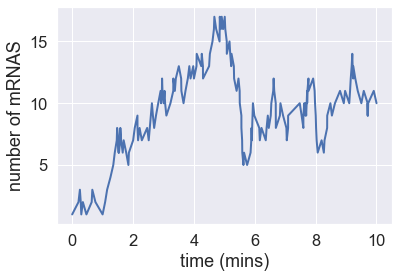

In [7]:
plt.plot(t,m)
plt.xlabel("time (mins)")
plt.ylabel("number of mRNAS")

## Problem 1

Due to the random nature of a stochastic process, a single simulation may not be representative. To get a better sense of how this system will behave *on average*, use a `for` loop to repeat our stochastic simulation 100 times. Plot each of these simulations on the same plot to see how much variability there can be from simulation to simulation. Remember you can use the `alpha` variable to make your plots more transparent and easier to visualize many on top of each other.

## Problem 2

Numerically integrate the $ \frac{\mathrm{d}m}{\mathrm{d}t} = \beta_m - \gamma_m m$ differential equation, using one of our previous methods (Euler, `scipy`, etc.). Plot the results of your numerical integration on top of your stochastic simulations from Problem 2. How do the results compare?

## Problem 3

Expand our simulation from class to now keep track of both an mRNA and protein populations.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & \gamma_m m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma_p p.
\end{array}
\end{align}

Below I specify the parameters you should use for this simulation. Since the number of mRNAs and the number of proteins are substantially different, plot their trajectories over time on separate plots. 

In [8]:
# specifying the parameters
beta_m = 10 # per min
gamma_m = 1 # per min, per transcript
beta_p = 10 # per min
gamma_p = 0.5 # per min, per protein

# how long we want run simulation for
total_time = 20 # mins

## Problem 4

Returning to the original equations, what are the expected steady-state / fixed point values for the number of mRNAs and proteins? Calculate precise numbers based on the parameter values we've used here. How do these expected value compare to what you see in your simulation?

## Attribution

Materials for this notebook were borrowed from © 2019 [Justin Bois](http://bois.caltech.edu/teaching.html), as licensed under a Creative Commons Attribution License CC-BY 4.0. All code contained herein is licensed under an MIT license.